In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

In [2]:
# Membaca file CSV
df = pd.read_csv('data_harga_beras.csv')
# Mengonversi kolom 'Date' menjadi tipe data datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').interpolate(method='linear').reset_index()

# Menampilkan dataframe
df

,Date,C4Super,C4Medium,Bulog
0,2021-01-04,11750.0,10667.000000,9083.0
1,2021-01-05,11750.0,10667.000000,9083.0
2,2021-01-06,11750.0,10667.000000,9083.0
3,2021-01-07,11750.0,10667.000000,9083.0
4,2021-01-08,11750.0,10667.000000,9083.0
...,...,...,...,...
1208,2024-04-26,16167.0,14667.000000,11000.0
1209,2024-04-27,15889.0,14444.666667,11000.0
1210,2024-04-28,15611.0,14222.333333,11000.0
1211,2024-04-29,15333.0,14000.000000,11000.0


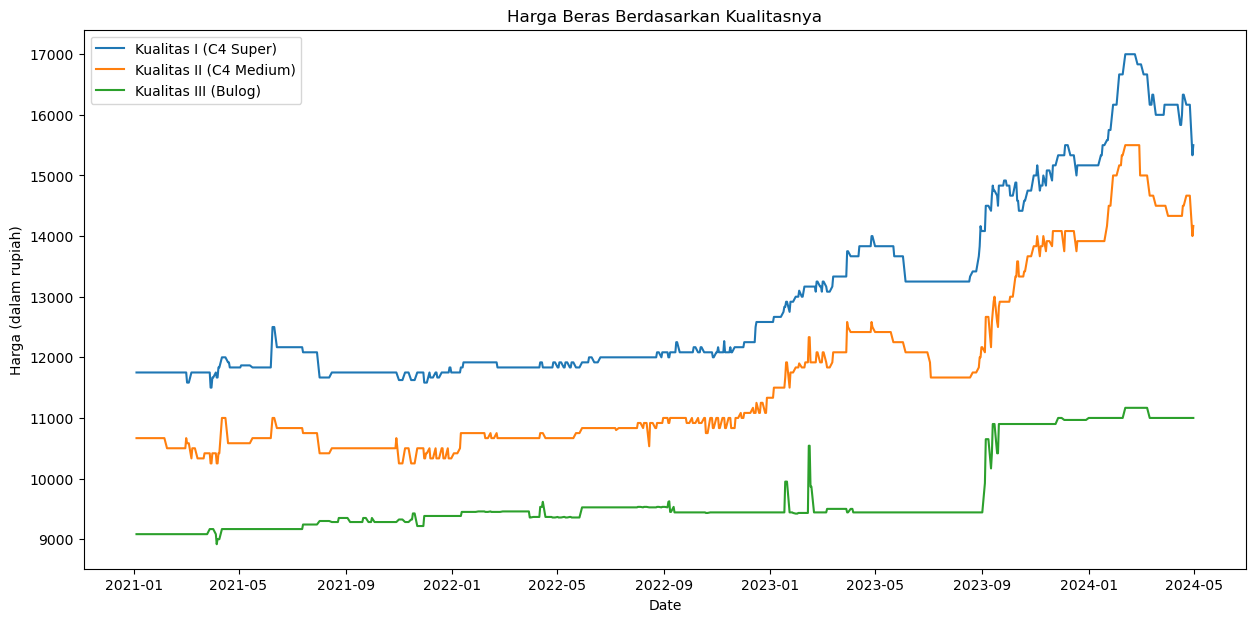

In [3]:
plt.figure(figsize=(15,7))
plt.plot(df['Date'], df['C4Super'], label='Kualitas I (C4 Super)')
plt.plot(df['Date'], df['C4Medium'], label='Kualitas II (C4 Medium)')
plt.plot(df['Date'], df['Bulog'], label='Kualitas III (Bulog)')

# Menambahkan label untuk sumbu x, sumbu y, dan judul grafik
plt.xlabel('Date')
plt.ylabel('Harga (dalam rupiah)')
plt.title('Harga Beras Berdasarkan Kualitasnya')
# Menampilkan legenda
plt.legend()

# Menampilkan grafik
plt.show()

In [4]:
#Menampilkan informasi tentang DataFrame `df`
df.info()

# Menampilkan statistik deskriptif dari DataFrame `df`
df.describe()

# Memeriksa jumlah nilai null (missing values) dalam setiap kolom 
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1213 non-null   datetime64[ns]
 1   C4Super   1213 non-null   float64       
 2   C4Medium  1213 non-null   float64       
 3   Bulog     1213 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 38.0 KB


Date        0
C4Super     0
C4Medium    0
Bulog       0
dtype: int64

In [5]:
# Menetapkan random seed
tf.random.set_seed(123)

In [6]:
# Melakukan drop pada kolom 'C4 Medium' dan 'Bulog'
df = df.drop(['C4Super', 'Bulog'], axis=1)

In [7]:
# Mengambil nilai dari kolom 'C4Medium', mengonversinya menjadi array, dan mengubah tipe data menjadi float32
df = df.filter(['C4Medium'])
df = df.values
df = df.astype('float32')

In [8]:
# Normalisasi dataset dengan MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
print(df)


[[0.07942867]
 [0.07942867]
 [0.07942867]
 ...
 [0.75663495]
 [0.71428585]
 [0.7460952 ]]


In [9]:
# Time series windowing 
def prepare_data(df, timesteps):
    X = []
    Y = []
    for i in range(len(df)-timesteps-1):
        X.append(df[i:(i+timesteps)])
        Y.append(df[i + timesteps, 0])  # Hanya kolom 'C4Medium' yang menjadi target
    return np.array(X), np.array(Y)

# Menentukan jumlah time steps (hari) yang digunakan untuk memprediksi harga beras berikutnya
timesteps = 1


In [10]:
# Membagi dataset menjadi data latih dan data uji
n_samples = len(df)
train_size = int(n_samples * 0.7)
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

# Persiapkan input dan output
X_train, Y_train = prepare_data(train_data, timesteps)
X_test, Y_test = prepare_data(test_data, timesteps)

In [11]:
# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print('Train Shape = {0}'.format(X_train.shape))
print('Test Shape = {0}'.format(X_test.shape))


Train Shape = (847, 1, 1)
Test Shape = (362, 1, 1)


In [12]:
# Inisiasi Hyperparameter
num_neuron = 30
num_epoch = 50
num_batch = 16
adam_optimizer = Adam(learning_rate=0.001)

# Membuat model LSTM
model = Sequential()
model.add(LSTM(4, activation='tanh', recurrent_activation='sigmoid', 
               return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(num_neuron, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, bias_initializer='zeros'))

model.summary()

# Build model and compile
model.compile(optimizer=adam_optimizer, loss='mse', metrics=['MAPE'])

# Melatih model dengan menggunakan set data Training
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epoch, batch_size=num_batch, verbose=1)

C:\Users\Windows\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 4)           │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,327 (16.90 KB)

 Trainable params: 4,327 (16.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - MAPE: 567893.4375 - loss: 0.0197 - val_MAPE: 73.5160 - val_loss: 0.2589
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - MAPE: 2544274.0000 - loss: 0.0100 - val_MAPE: 70.6695 - val_loss: 0.2401
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 2365614.7500 - loss: 0.0093 - val_MAPE: 66.1182 - val_loss: 0.2105
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 2217136.5000 - loss: 0.0079 - val_MAPE: 58.6816 - val_loss: 0.1646
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 2032381.8750 - loss: 0.0063 - val_MAPE: 45.5570 - val_loss: 0.0970
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 1708621.5000 - loss: 0.0036 - val_MAPE: 27.3971 - val_loss: 0.0320
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 1032661.2500 - loss: 0.0021 - val_MAPE: 9.8229 - val_loss: 0.0030
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - MAPE: 829905.4375 - loss: 0.0014 - val_MAPE: 4.4235 - val_loss: 7.7999e-04

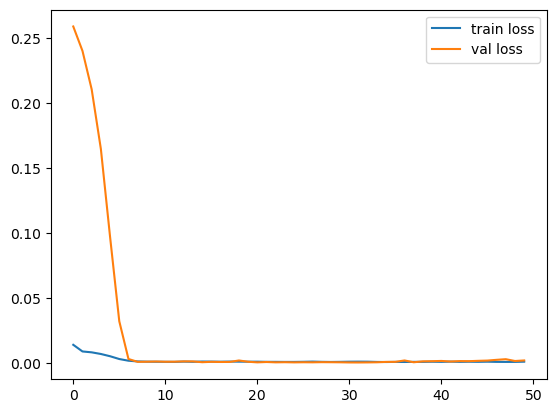

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [14]:
# Predicting
train_predict = model.predict(X_train, verbose=0)
test_predict = model.predict(X_test, verbose=0)

print("Hasil prediksi pada data latih (normalisasi):")
print(train_predict)

print("Hasil prediksi pada data uji (normalisasi):")
print(test_predict)

Hasil prediksi pada data latih (normalisasi):
[[0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.080062  ]
 [0.07044264]
 [0.06087079]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.080062  ]
 [0.06556469]
 [0.06556469]
 [0.06556469]
 [0.05129124]
 [0.03713126]
 [0.02309041]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [0.05134804]
 [

In [15]:
# Menghitung MAE
mae = mean_absolute_error(Y_test, test_predict)
print('MAE = ', round(mae, 4))

# Hitung RMSE
rmse = sqrt(mean_squared_error(Y_test, test_predict))
print('RMSE = ', round(rmse, 4))

test_mape = model.evaluate(X_test, Y_test)
print(f'Test MAPE: {test_mape[1]}')

MAE =  0.035
RMSE =  0.0431
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MAPE: 4.6635 - loss: 9.5834e-04 
Test MAPE: 5.434525966644287


In [16]:
# Visualisasi data test (aktual) dan data hasil prediksi
plot_predict_test = model.predict(X_test, verbose=0)
plot_predict_train = model.predict(X_train, verbose=0)

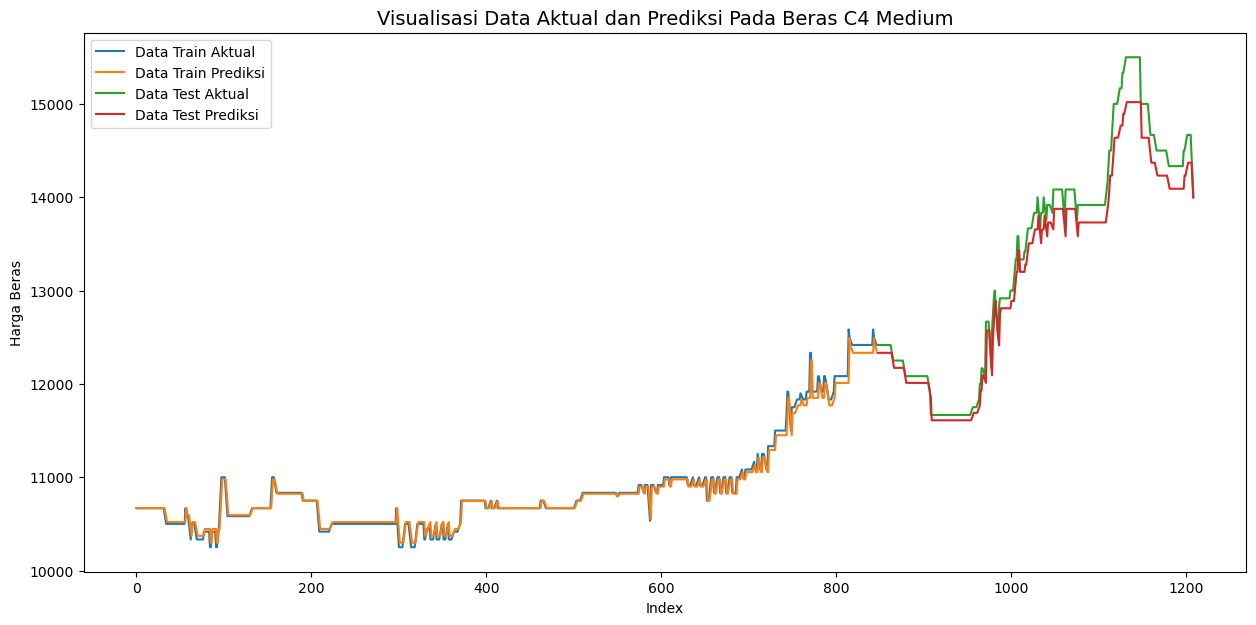

In [17]:
# denormalisasi  
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], 2))), axis=1))[:, 0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 2))), axis=1))[:, 0]
plot_predict_train = scaler.inverse_transform(np.concatenate((plot_predict_train, np.zeros((plot_predict_train.shape[0], 2))), axis=1))[:, 0]
plot_predict_test = scaler.inverse_transform(np.concatenate((plot_predict_test, np.zeros((plot_predict_test.shape[0], 2))), axis=1))[:, 0]

plt.figure(figsize=(15,7))
plt.plot(np.arange(len(Y_train)), Y_train, label='Data Train Aktual')
plt.plot(np.arange(len(Y_train)), plot_predict_train, label='Data Train Prediksi')
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Data Test Aktual')
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), plot_predict_test, label='Data Test Prediksi')
plt.title('Visualisasi Data Aktual dan Prediksi Pada Beras C4 Medium', fontsize=14)
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.legend()
plt.show()


In [18]:
# Menampilkan Data Test dan Prediksi dalam bentuk tabel
results = pd.DataFrame({
    'Data Test': Y_test,
    'Data Predict LSTM': plot_predict_test
})
print(results.head(10))
print(results.tail(10))

     Data Test  Data Predict LSTM
0  12416.99995       12332.538998
1  12416.99995       12332.538998
2  12416.99995       12332.538998
3  12416.99995       12332.538998
4  12416.99995       12332.538998
5  12416.99995       12332.538998
6  12416.99995       12332.538998
7  12416.99995       12332.538998
8  12416.99995       12332.538998
9  12416.99995       12332.538998
        Data Test  Data Predict LSTM
352  14555.666662       14231.584016
353  14611.333407       14277.950961
354  14667.000153       14324.030955
355  14667.000153       14369.821181
356  14667.000153       14369.821181
357  14667.000153       14369.821181
358  14667.000153       14369.821181
359  14444.667375       14369.821181
360  14222.333345       14185.214880
361  14000.000567       13996.129692


In [19]:
mape = mean_absolute_percentage_error(Y_test, plot_predict_test)
mape_percentage = round(mape * 100, 4)
print(f'Nilai MAPE = {mape_percentage}%')

Nilai MAPE = 1.3148%
